# 1. Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed
import warnings
warnings.filterwarnings("ignore")
set_random_seed(99)

C:\Users\namtrantuan\AppData\Roaming\Python\Python39\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
pd.options.display.float_format = '{:20,.0f}'.format

In [3]:
dom = pd.read_excel('dom.xlsx')
dom = dom.rename(columns={'DATE': 'ds', 'Pax': 'y'})

In [4]:
dom.head()

,ds,y,seat
0,2015-01-01,52356,59972
1,2015-01-02,47811,56277
2,2015-01-03,49555,60035
3,2015-01-04,57680,62548
4,2015-01-05,50193,58566


In [5]:
dom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2977 non-null   datetime64[ns]
 1   y       2977 non-null   int64         
 2   seat    2977 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 69.9 KB


<AxesSubplot:xlabel='ds'>

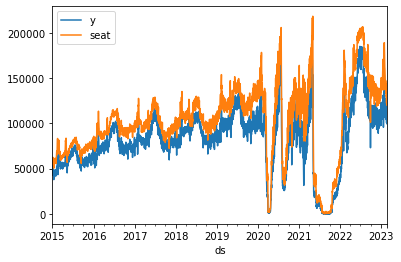

In [6]:
dom.set_index('ds').plot()

In [7]:
holidays = pd.read_excel('holidays.xlsx')

In [8]:
# changepoints là những mốc bắt đầu và kết thúc của các đợt dịch covid hoặc thay đổi về trend:
changepoints = ['2020-03-09','2020-05-31','2020-07-28','2020-09-30','2021-01-25','2021-03-31','2021-04-30','2021-10-22']

# 2. Build models

In [9]:
train = dom[dom['ds'] < '2022-07-01'].copy()
val = dom[(dom['ds'] >= '2022-07-01')&(dom['ds'] < '2023-01-01')].copy()
test = dom[dom['ds'] >= '2023-01-01'].copy()

In [10]:
holidays = holidays.rename(columns={'holiday': 'event'})
train_holidays = holidays[holidays['ds'] < '2022-07-01'].copy()
val_holidays = holidays[(holidays['ds'] >= '2022-07-01')&(holidays['ds'] < '2023-01-01')].copy()
test_holidays = holidays[holidays['ds'] >= '2023-01-01'].copy()

In [11]:
help(NeuralProphet)

Help on class NeuralProphet in module neuralprophet.forecaster:

class NeuralProphet(builtins.object)
 |  NeuralProphet(growth: Literal['off', 'linear', 'discontinuous'] = 'linear', changepoints: Optional[list] = None, n_changepoints: int = 10, changepoints_range: float = 0.8, trend_reg: float = 0, trend_reg_threshold: Union[bool, float, NoneType] = False, trend_global_local: str = 'global', yearly_seasonality: Union[Literal['auto'], bool, int] = 'auto', weekly_seasonality: Union[Literal['auto'], bool, int] = 'auto', daily_seasonality: Union[Literal['auto'], bool, int] = 'auto', seasonality_mode: Literal['additive', 'multiplicative'] = 'additive', seasonality_reg: float = 0, season_global_local: Literal['global', 'local'] = 'global', n_forecasts: int = 1, n_lags: int = 0, num_hidden_layers: int = 0, d_hidden: Optional[int] = None, ar_reg: Optional[float] = None, learning_rate: Optional[float] = None, epochs: Optional[int] = None, batch_size: Optional[int] = None, loss_func: Union[str, 

In [12]:
def objective(trial):
    set_random_seed(99)
    """Define the objective function"""

    params = {
        'trend_reg': trial.suggest_float('trend_reg',0.001,10),
        'seasonality_reg': trial.suggest_float('seasonality_reg',0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode',['multiplicative', 'additive']),
        'yearly_seasonality':trial.suggest_int('yearly_seasonality',10,40),
        'weekly_seasonality':trial.suggest_int('weekly_seasonality',1,20),
        'n_lags':trial.suggest_int('n_lags',1,366),
        'ar_reg':trial.suggest_float('ar_reg',0,10),
        #'newer_samples_weight':trial.suggest_float('newer_samples_weight',0,10),
        'learning_rate':trial.suggest_float('learning_rate',0.001,5),
        #'num_hidden_layers':trial.suggest_int('num_hidden_layers',0,2)
    }
    lagged_regressor_params = {'regularization':trial.suggest_float('regularization',0,1)}
    
    # Create the model
    optuna_model = NeuralProphet(**params, changepoints = changepoints, daily_seasonality = False, n_forecasts = 365)
    optuna_model.add_events(events = ['covid_1','covid_2','covid_3','covid_4'], mode='multiplicative')  
    optuna_model.add_events(events = ['Labor','Lunar','Summer'], mode='multiplicative')
    optuna_model.add_lagged_regressor('seat', **lagged_regressor_params)
    
    # create the data df with events
    train_df = optuna_model.create_df_with_events(train, train_holidays)
    val_df = optuna_model.create_df_with_events(val, val_holidays)
    
    # Fit the model
    metrics = optuna_model.fit(train_df, freq="D")

    # Make predictions
    future_df = optuna_model.make_future_dataframe(train_df, events_df=holidays)
    optuna_forecast = optuna_model.predict(df=future_df)
    latest = optuna_model.get_latest_forecast(optuna_forecast)

    # Evaluate prediction
    result = val_df.merge(latest,how = 'left', on = 'ds')
    result.set_index('ds', inplace = True)
    rmse = np.sqrt(mean_squared_error(result['y_x'], result['origin-0'])).round(0)
    return rmse

In [13]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=99))

[I 2023-03-01 16:47:48,748] A new study created in memory with name: no-name-7ff37d91-0537-417f-b107-cb12828c60a4


In [14]:
study.optimize(objective, n_trials=10)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (109)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-01 16:50:27,178] Trial 0 finished with value: 18110.0 and parameters: {'trend_reg': 6.723113307749288, 'seasonality_reg': 4.931976152481779, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 35, 'weekly_seasonality': 12, 'n_lags': 109, 'ar_reg': 0.46695720506953253, 'learning_rate': 4.95314636995451, 'regularization': 0.006825733043655191}. Best is trial 0 with value: 18110.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (357)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecast

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.861% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.861% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-01 16:52:56,610] Trial 1 finished with value: 122681.0 and parameters: {'trend_reg': 7.698160488871209, 'seasonality_reg': 7.492994299843566, 'seasonality_mode': 'additive', 'yearly_seasonality': 38, 'weekly_seasonality': 8, 'n_lags': 357, 'ar_reg': 5.244147153752401, 'learning_rate': 0.4689718533954651, 'regularization': 0.813308412782129}. Best is trial 0 with value: 18110.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (237)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.834% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-01 16:55:25,191] Trial 2 finished with value: 25389.0 and parameters: {'trend_reg': 2.1176561691080455, 'seasonality_reg': 5.588023267447785, 'seasonality_mode': 'additive', 'yearly_seasonality': 35, 'weekly_seasonality': 5, 'n_lags': 237, 'ar_reg': 0.9518162193353041, 'learning_rate': 2.058904530975849, 'regularization': 0.09686526126266715}. Best is trial 0 with value: 18110.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (329)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit)

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-01 16:57:25,496] Trial 3 finished with value: 114532.0 and parameters: {'trend_reg': 1.4409659780779387, 'seasonality_reg': 2.2007421356240147, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 1, 'n_lags': 329, 'ar_reg': 5.522344268776632, 'learning_rate': 0.8385655919438032, 'regularization': 0.9288781834957359}. Best is trial 0 with value: 18110.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (93)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaste

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.782% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.782% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-01 17:00:16,681] Trial 4 finished with value: 98006.0 and parameters: {'trend_reg': 5.421334900480403, 'seasonality_reg': 0.513409459812975, 'seasonality_mode': 'additive', 'yearly_seasonality': 34, 'weekly_seasonality': 17, 'n_lags': 93, 'ar_reg': 9.682735127752839, 'learning_rate': 2.331724435414501, 'regularization': 0.264091169854872}. Best is trial 0 with value: 18110.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (159)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - W

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.809% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.809% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-01 17:03:20,475] Trial 5 finished with value: 19026.0 and parameters: {'trend_reg': 5.4942347997429035, 'seasonality_reg': 3.8356044937294285, 'seasonality_mode': 'additive', 'yearly_seasonality': 39, 'weekly_seasonality': 17, 'n_lags': 159, 'ar_reg': 7.161129519222669, 'learning_rate': 4.256868609368256, 'regularization': 0.0790466853113343}. Best is trial 0 with value: 18110.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (108)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit)

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.789% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-01 17:05:39,054] Trial 6 finished with value: 16730.0 and parameters: {'trend_reg': 4.100175402884403, 'seasonality_reg': 6.45154399765729, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 5, 'n_lags': 108, 'ar_reg': 1.6001007403150314, 'learning_rate': 1.5203620857142972, 'regularization': 0.7185063797778265}. Best is trial 6 with value: 16730.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (303)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.85% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.85% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-01 17:08:26,560] Trial 7 finished with value: 93225.0 and parameters: {'trend_reg': 9.57984200939192, 'seasonality_reg': 0.2562439814963622, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 37, 'weekly_seasonality': 14, 'n_lags': 303, 'ar_reg': 9.183481487085025, 'learning_rate': 0.7664391555341886, 'regularization': 0.47002862075489793}. Best is trial 6 with value: 16730.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (225)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaste

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-01 17:10:30,791] Trial 8 finished with value: 25798.0 and parameters: {'trend_reg': 5.463140085069839, 'seasonality_reg': 5.21090379223616, 'seasonality_mode': 'additive', 'yearly_seasonality': 17, 'weekly_seasonality': 3, 'n_lags': 225, 'ar_reg': 2.4365630403016656, 'learning_rate': 4.1349053608917705, 'regularization': 0.46552921506558087}. Best is trial 6 with value: 16730.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (200)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-03-01 17:12:28,837] Trial 9 finished with value: 20791.0 and parameters: {'trend_reg': 6.910607756605617, 'seasonality_reg': 3.612549841498813, 'seasonality_mode': 'additive', 'yearly_seasonality': 15, 'weekly_seasonality': 5, 'n_lags': 200, 'ar_reg': 3.5491121674008, 'learning_rate': 3.72349161272694, 'regularization': 0.6481588203970642}. Best is trial 6 with value: 16730.0.


In [15]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 10
Best trial:
  Value: 16730.0
  Params: 
    trend_reg: 4.100175402884403
    seasonality_reg: 6.45154399765729
    seasonality_mode: multiplicative
    yearly_seasonality: 29
    weekly_seasonality: 5
    n_lags: 108
    ar_reg: 1.6001007403150314
    learning_rate: 1.5203620857142972
    regularization: 0.7185063797778265


In [16]:
regularization = trial.params.pop('regularization')

In [17]:
trial.params

{'trend_reg': 4.100175402884403,
 'seasonality_reg': 6.45154399765729,
 'seasonality_mode': 'multiplicative',
 'yearly_seasonality': 29,
 'weekly_seasonality': 5,
 'n_lags': 108,
 'ar_reg': 1.6001007403150314,
 'learning_rate': 1.5203620857142972}

In [18]:
#params = study2.trials[4].params
params = trial.params

In [19]:
set_random_seed(99)

In [20]:
m = NeuralProphet(**params, changepoints = changepoints, daily_seasonality = False, n_forecasts = 365)
m.add_events(events = ['covid_1','covid_2','covid_3','covid_4'], mode='multiplicative')
m.add_events(events = ['Labor','Lunar','Summer'], mode='multiplicative')
m.add_lagged_regressor('seat', regularization = regularization)

# create the data df with events
train_df = m.create_df_with_events(train, train_holidays)
val_df = m.create_df_with_events(val, val_holidays)
train_val_df = pd.concat([train_df,val_df])
test_df = m.create_df_with_events(test, test_holidays)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (108)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 149


Training: 0it [00:00, ?it/s]

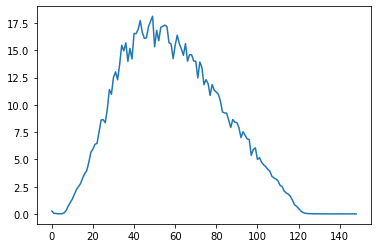

In [21]:
metrics = m.fit(train_val_df,
                freq="D",
                progress="plot")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


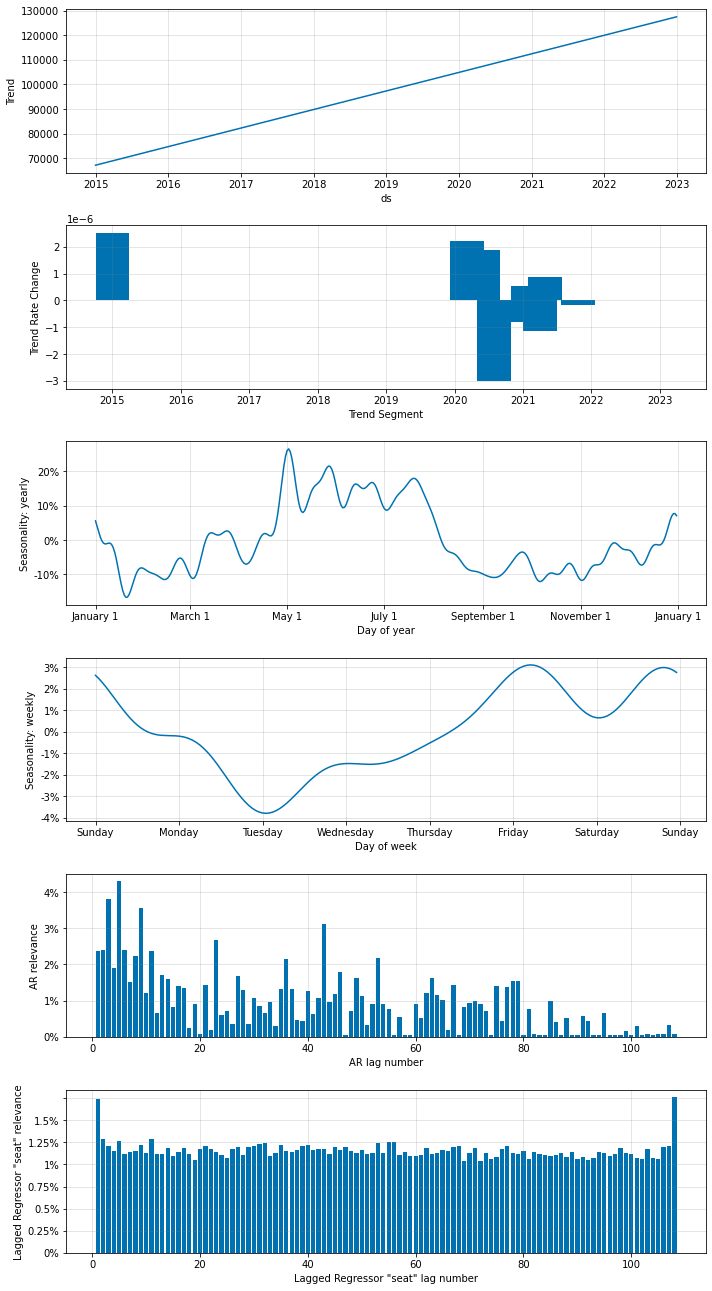

In [22]:
fig_param = m.plot_parameters()

In [23]:
future = m.make_future_dataframe(train_val_df, n_historic_predictions=True, events_df=holidays)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [24]:
future[(future['ds']>='2023-01-01')&(future['ds']<'2023-02-01')]

,ds,y,seat,covid_1,covid_2,covid_3,covid_4,Labor,Lunar,Summer
2922,2023-01-01,None,None,0,0,0,0,0,0,0
2923,2023-01-02,None,None,0,0,0,0,0,0,0
2924,2023-01-03,None,None,0,0,0,0,0,0,0
2925,2023-01-04,None,None,0,0,0,0,0,0,0
2926,2023-01-05,None,None,0,0,0,0,0,0,0
2927,2023-01-06,None,None,0,0,0,0,0,0,0
2928,2023-01-07,None,None,0,0,0,0,0,0,0
2929,2023-01-08,None,None,0,0,0,0,0,0,0
2930,2023-01-09,None,None,0,0,0,0,0,0,0
2931,2023-01-10,None,None,0,0,0,0,0,0,0


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.97% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.97% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 77it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


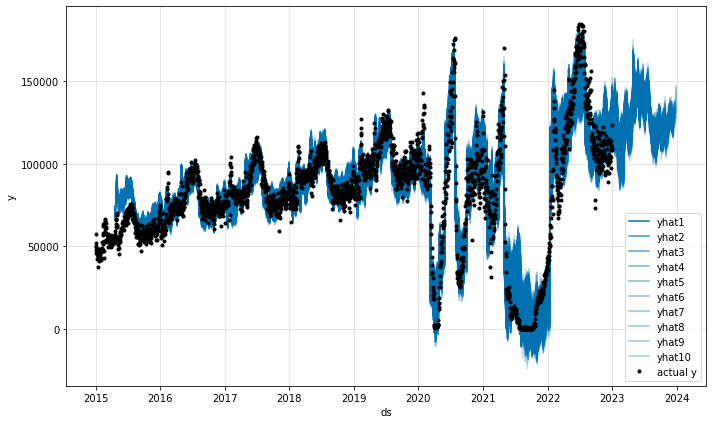

In [25]:
forecast = m.predict(future, decompose = False)
fig = m.plot(forecast)

In [26]:
forecast

,ds,y,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,yhat8,...,yhat356,yhat357,yhat358,yhat359,yhat360,yhat361,yhat362,yhat363,yhat364,yhat365
0,2015-01-01,"52,356",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,"47,811",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,"49,555",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,"57,680",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,"50,193",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,2023-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"133,579","133,055","133,032","133,755","132,999"
3283,2023-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"139,252","138,911","142,332","141,888"
3284,2023-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"144,160","147,307","147,099"
3285,2023-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"141,404","141,307"


In [27]:
latest = m.get_latest_forecast(forecast,include_history_data=True)

In [28]:
latest.to_excel('latest.xlsx')

In [29]:
forecast.to_excel('result.xlsx')

In [30]:
# Calculate rmse and mape:
rmse = np.sqrt(mean_squared_error(predicted['y'][-len(test):], predicted['yhat1'][-len(test):])).round(2)
mape = np.round(np.mean(np.abs(predicted['y'][-len(test):]-predicted['yhat1'][-len(test):])/predicted['y'][-len(test):])*100,2)
tempResults = pd.DataFrame({'Method':'neural prophet', 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

NameError: name 'predicted' is not defined

In [ ]:
predicted.to_excel('result.xlsx')

In [ ]:
np.mean(np.abs(predicted['y']-predicted['yhat1'])/predicted['y'])*100

In [ ]:
result = val_df.merge(latest,how = 'left', on = 'ds')

In [ ]:
result